# Experiments with linear models for each family

In [18]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

In [19]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import pdpipe as pdp
import collections
from pandas.core.common import SettingWithCopyWarning
from sklearn.base import BaseEstimator, RegressorMixin, MetaEstimatorMixin, TransformerMixin, clone
from datetime import timedelta
from pdpipe import df
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_score, TimeSeriesSplit, GridSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from mentorship.ml.models.reg import PositiveRegressor
from mentorship.ml.models.common import SplitPipeline
from mentorship.ml.models.kaggle.storesales.linear import PipelineLinearV1, PipelineRidgeV1, PipelineLassoV1, PipelineElasticNetV1
from mentorship.features.kaggle.storesales.etl import ETLTransformer
from mentorship.features.history import cut_history
from mentorship.ml.cv.split import DateTimeSeriesSplit
from mentorship.ml.cv.util import print_cv_test_scores


%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [20]:
CV_METRICS = [
    'neg_mean_squared_log_error',
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error',
    # 'neg_mean_absolute_percentage_error',
    'r2'
]

In [21]:
DATA_ROOT = Path('data', 'kaggle', 'store-sales-time-series-forecasting')

In [22]:
train = pd.read_csv(DATA_ROOT / 'train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [23]:
N_STORES = train['store_nbr'].nunique()
N_FAMILIES = train['family'].nunique()
N_TIME_SERIES = N_STORES * N_FAMILIES

DAYS_IN_YEAR = 365
N_HORIZONS = 16

In [24]:
def make_submission_file(test_data, model, output_path):
    submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
    submission['sales'] = model.predict(test_data)
    submission.to_csv(DATA_ROOT / output_path, index = False)

In [25]:
def ts_cross_val_predict(modelling_pipeline, X, y, cv):
    # return a dictionary: fold number -> 1-d pd.Series of fold
    # predictions with index corresponding to X and y index
    predictions = {}
    fold_number = 1
    for train_indices, test_indices in cv.split(X, y):
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_test = X.iloc[test_indices]
        y_test = y.iloc[test_indices]

        modelling_pipeline.fit(X_train, y_train)
        current_fold_preds = modelling_pipeline.predict(X_test)
        predictions[fold_number] = current_fold_preds
        fold_number += 1
        
    return predictions

In [26]:
def scores_for_each_horizon(modelling_pipeline, X, y, splitter, date_column='date'):
    keys = np.arange(1, 17)
    cv_scores = {key : [] for key in keys}
    for train_indices, test_indices in splitter.split(X, y):
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_test = X.iloc[test_indices]
        y_test = y.iloc[test_indices]

        modelling_pipeline = modelling_pipeline.fit(X_train, y_train)
        
        for day_index, current_day in enumerate(X_test[date_column].unique()):
            X_test_current_day = X_test[X_test[date_column] == current_day]
            y_test_current_day = y_test.loc[X_test_current_day.index]
        
            y_pred = modelling_pipeline.predict(X_test_current_day)
            cv_scores[day_index + 1].append(mean_squared_log_error(y_test_current_day, y_pred, squared=False))
            
    return cv_scores

In [27]:
def nested_cv(estimator, X, y, base_pipeline, hyper_params_grid, tscv_inner, tscv_outer, split_key):
    scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}
    for train_indices, test_indices in tscv_outer.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
        X_test.loc[:, 'pred'] = 0
        for current_split_key_value in X[split_key].unique():
            X_train_current_split_key_value = X_train[X_train[split_key] == current_split_key_value].drop(columns=split_key)
            y_train_current_split_key_value = y_train.loc[X_train_current_split_key_value.index]
            X_test_current_split_key_value = X_test[X_test[split_key] == current_split_key_value].drop(columns=split_key)
        
            X_train_current_split_key_value = base_pipeline.pipeline(X_train_current_split_key_value)
    
            params_tuning_model = GridSearchCV(estimator=estimator, param_grid=hyper_params_grid, \
                                               scoring='neg_mean_squared_log_error', cv=tscv_inner)
            params_tuning_model.fit(X_train_current_split_key_value, y_train_current_split_key_value)
        
            model = PositiveRegressor(estimator(**params_tuning_model.best_params_)) \
                                        .fit(X_train_current_split_key_value, y_train_current_split_key_value)
        
            X_test_current_split_key_value = base_pipeline.pipeline(X_test_current_split_key_value)
            X_test.loc[X_test_current_split_key_value.index, 'pred'] = model.predict(X_test_current_split_key_value.drop(columns=['pred']))
        
        y_pred = X_test['pred'].copy()
        scores['RMSLE'].append(mean_squared_log_error(y_test, y_pred, squared=False))
        scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
        scores['MAE'].append(mean_absolute_error(y_test, y_pred))
        scores['R2'].append(r2_score(y_test, y_pred))
    
    return scores

# 0. Linear regression (one for all families) with 'store_nbr' and 'dcoilwtico' features

In [ ]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [ ]:
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr', 'family']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    current_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, \
                                        drop_columns=drop_columns)
    X_train = current_pipeline.pipeline(X_train)
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train, y_train)
    
    X_test = current_pipeline.pipeline(X_test)
    
    y_pred = model.predict(X_test)
    scores['RMSLE'].append(mean_squared_log_error(y_test, y_pred, squared=False))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

In [ ]:
print(scores)

In [ ]:
plt.plot(scores['RMSLE'])

# 1. Linear regression with 'store_nbr', 'dcoilwtico' and 'onpromotion' feature

<p><b>Preparing train data</b>

In [11]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [12]:
y = X['sales'].copy()
X = X.drop(columns='sales')
X.head()

,date,store_nbr,family,onpromotion,dcoilwtico
0,2013-01-01,1,automotive,0,NaN
1,2013-01-01,1,baby care,0,NaN
2,2013-01-01,1,beauty,0,NaN
3,2013-01-01,1,beverages,0,NaN
4,2013-01-01,1,books,0,NaN


<p><b>Cross-validation process</b>

In [13]:
split_key = 'family'
cols_to_scale = ['dcoilwtico', 'onpromotion']
cols_to_encode = ['store_nbr']
drop_columns = []

In [14]:
splitter = DateTimeSeriesSplit()

In [16]:
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [17]:
cv_preds = ts_cross_val_predict(modelling_pipeline, X, y, cv=splitter)

In [18]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)
print_cv_test_scores(scores)

root_mean_squared_log_error: 0.577 ± 0.068
root_mean_squared_error: 399.267 ± 37.458
mean_absolute_error: 110.609 ± 6.912
r2: 0.905 ± 0.012


In [22]:
cv_scores = scores_for_each_horizon(modelling_pipeline, X, y, splitter=splitter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


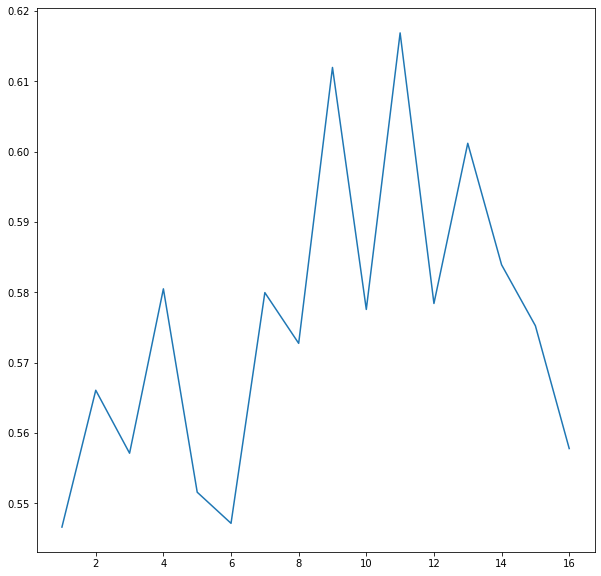

In [23]:
# RMSLE for every day in the test set

plt.figure(figsize=(10, 10))
x = list(cv_scores.keys())
y = [np.mean(cv_scores[key]) for key in x]
plt.plot(x, y)

<p><b>Test data preparing</b></p>

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(date_column='date', id_column='id')

In [ ]:
test_data = test_transformer.transform(test_data)[0]

In [ ]:
test_data.head()

<p><b>Training models and saving predictions</b>

In [ ]:
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
make_submission_file(test_data, model=modelling_pipeline, output_path='linreg_dcoilwtico_promo.csv')

# 2. Linear regression with 'store_nbr' and 'time-step' feature

<p><b>Train data preparing</b>

In [ ]:
X = train.copy()

In [ ]:
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]
X = train_transformer.adding_time_step(X)

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
split_key = 'family'
cols_to_scale = []
cols_to_encode = ['store_nbr']
drop_columns = ['dcoilwtico', 'onpromotion']

<p><b>Cross-validation process</b>

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

<p><b>Test data preparing</b>

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data = test_transformer.adding_time_step(test_data)
# test_dates['time'] = np.arange(len(X_dates.index), len(X_dates.index) + len(test_dates.index))

<p><b>Training models and saving predictions</b>

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
make_submission_file(test_data, model=modelling_pipeline, output_path='linreg_timestep.csv')

# 3. Linear regression with 'store_nbr' and 'dcoilwtico' features

<p><b>Train data preparing</b>

In [ ]:
X = train.copy()

In [ ]:
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

<p><b>Cross-validation process</b>

In [ ]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

In [ ]:
cv_scores = scores_for_each_horizon(estimator=LinearRegression(), X=X, y=y, splitter=splitter, \
                                    base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
# RMSLE for every day in the test set

plt.figure(figsize=(10, 10))
x = list(cv_scores.keys())
y = [np.mean(cv_scores[key]) for key in x]
plt.plot(x, y)

<p><b>Test data preparing</b>

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

<p><b>Training models and saving predictions</b>

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
make_submission_file(test_data, model=modelling_pipeline, output_path='linreg_dcoilwtico.csv') 

# 4. Linear regression with 'store_nbr', 'dcoilwtico' and 'time-step' features

In [ ]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]
X = train_transformer.adding_time_step(X)

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

# 5. Linear Regression with 'store_nbr', 'dcoilwtico' and 'is_holiday' binary feature

In [ ]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]
X.loc[:, 'is_holiday'] = train_transformer.adding_is_holiday_feature(X)

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data.loc[:, 'is_holiday'] = train_transformer.adding_is_holiday_feature(test_data)

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
make_submission_file(test_data, model=modelling_pipeline, output_path='linreg_dcoilwtico_is_holiday.csv') 

# 6. Linear Regression with 'store_nbr', 'dcoilwtico' and 'store_type' features 

In [ ]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
X = train_transformer.adding_stores_data(X, columns_to_add=['type'])

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
X.head()

In [ ]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr', 'store_type']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

# 7. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (16 days)

In [ ]:
X = train.copy()
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
dates_test_data = test_data['date'].unique()
all_data = pd.concat([X, test_data])
all_data['lag_16'] = all_data.groupby(['store_nbr', 'family'])['sales'].shift(16)

In [ ]:
test_data['lag_16'] = all_data[all_data['date'].isin(dates_test_data)]['lag_16']
X['lag_16'] = all_data[~all_data['date'].isin(dates_test_data)]['lag_16']

In [ ]:
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
split_key = 'family'
cols_to_scale = ['dcoilwtico', 'lag_16']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline, split_key=split_key)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

In [ ]:
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
make_submission_file(test_data, model=modelling_pipeline, output_path='linreg_dcoilwtico_lag16.csv') 

# 8. Ridge Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (16 days), params: alpha

In [28]:
X = train.copy()
test_data = pd.read_csv(DATA_ROOT / 'test.csv')

test_dates = test_data['date'].unique()
all_data = pd.concat([X, test_data])
all_data['lag_16'] = all_data.groupby(['store_nbr', 'family'])['sales'].shift(16)

test_data = all_data[all_data['date'].isin(test_dates)].drop(columns=['sales'])
X = all_data[~all_data['date'].isin(test_dates)]

In [29]:
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [30]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [43]:
hyper_params_grid = {'alpha': np.array([0.01, 0.1, 1])}

In [44]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']

In [47]:
def nested_cv(model, X, y, base_pipeline, hyper_params_grid, tscv_inner, tscv_outer, split_key, scoring):
    scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}
    for train_indices, test_indices in tscv_outer.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
        X_test.loc[:, 'pred'] = 0
        for current_split_key_value in X[split_key].unique():
            X_train_current_split_key_value = X_train[X_train[split_key] == current_split_key_value].drop(columns=split_key)
            y_train_current_split_key_value = y_train.loc[X_train_current_split_key_value.index]
            X_test_current_split_key_value = X_test[X_test[split_key] == current_split_key_value].drop(columns=split_key)
            
            X_train_current_split_key_value = base_pipeline.pipeline(X_train_current_split_key_value)
            
            params_tuning_model = GridSearchCV(estimator=model, param_grid=hyper_params_grid, scoring=scoring, cv=tscv_inner)
            params_tuning_model.fit(X_train_current_split_key_value, y_train_current_split_key_value)
            
            model = model.set_params(**params_tuning_model.best_params_)
            model = PositiveRegressor(model).fit(X_train_current_split_key_value, y_train_current_split_key_value)
            
            X_test_current_split_key_value = base_pipeline.pipeline(X_test_current_split_key_value)
            X_test.loc[X_test_current_split_key_value.index, 'pred'] = model.predict(X_test_current_split_key_value.drop(columns=['pred']))
            
        y_pred = X_test['pred'].copy()
        scores['RMSLE'].append(mean_squared_log_error(y_test, y_pred, squared=False))
        scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
        scores['MAE'].append(mean_absolute_error(y_test, y_pred))
        scores['R2'].append(r2_score(y_test, y_pred))
    
    return scores

In [48]:
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 60) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
tscv_outer = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4,
                             test_size=N_HORIZONS * N_TIME_SERIES)
base_pipeline = PipelineRidgeV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
scores = nested_cv(model=Ridge(), X=X, y=y, base_pipeline=base_pipeline, hyper_params_grid=hyper_params_grid,
                   tscv_inner=tscv_inner, tscv_outer=tscv_outer, split_key=split_key, scoring='neg_mean_absolute_error')

automotive
{'alpha': 0.1}
automotive
Ridge(alpha=0.1)
automotive
baby care
{'alpha': 0.1}
baby care
Ridge(alpha=0.1)
baby care
beauty
{'alpha': 1.0}
beauty
Ridge()
beauty
beverages


KeyboardInterrupt: 

In [ ]:
for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {np.mean(metric_values):.3f} ± {np.std(metric_values):.3f}')

In [ ]:
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
best_params = {}
tscv = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 60) * N_STORES, n_splits=4, test_size=N_HORIZONS * N_STORES)
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
for current_split_key_value in X[split_key].unique():
    X_train_current_split_key_value = X_train[X_train[split_key] == current_split_key_value].drop(columns=split_key)
    y_train_current_split_key_value = y_train.loc[X_train_current_split_key_value.index]
    
    base_pipeline = PipelineRidgeV1(cols_to_scale=cols_to_scale, cols_to_encode=cols_to_encode, drop_columns=drop_columns)
    X_train_current_split_key_value = base_pipeline.pipeline(X_train_current_split_key_value)
    
    params_tuning_model = GridSearchCV(estimator=Ridge(), param_grid=hyper_params_grid, cv=tscv)
    params_tuning_model.fit(X_train_current_split_key_value, y_train_current_split_key_value)
    
    model = Ridge(**params_tuning_model.best_params_).fit(X_train_current_split_key_value, y_train_current_split_key_value)
    test_data_current_split_key_value = test_data[test_data[split_key] == current_split_key_value].drop(columns=split_key)
    test_data_current_split_key_value = base_pipeline.pipeline(test_data_current_split_key_value)
    
    current_split_key_value_pred = model.predict(test_data_current_split_key_value)
    current_split_key_value_pred[current_split_key_value_pred < 0] = 0
    submission.loc[test_data_current_split_key_value.index, 'sales'] = current_split_key_value_pred
    
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/ridgereg_dcoilwtico_lag_sixteen.csv', index = False)

# *9. Lasso Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (16 days), params: alpha

In [ ]:
X = train.copy().drop(columns='onpromotion')
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
dates_test_data = test_data['date'].unique()
all_data = pd.concat([X, test_data])
all_data['lag_16'] = all_data.groupby(['store_nbr', 'family'])['sales'].shift(16)

test_data['lag_16'] = all_data[all_data['date'].isin(dates_test_data)]['lag_16']
X['lag_16'] = X.groupby(['store_nbr', 'family'])['sales'].shift(16)

train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

y = X['sales'].copy()
X = X.drop(columns='sales')
X.head()

In [ ]:
hyper_params = {'alpha': np.array([0.001, 0.01, 0.1, 1])}

In [ ]:
splitter = DateTimeSeriesSplit()
for alpha in hyper_params['alpha']:
    base_pipeline = PipelineLassoV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'], best_params=alpha)
    modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)
    
    scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)
    
    print('alpha: ', alpha)
    print_cv_test_scores(scores)
    print('/n/n')

In [ ]:
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data.head()

In [ ]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train = y.loc[indexer]

In [ ]:
base_pipeline = PipelineLassoV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'], best_params=0.001)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
submission['sales'] = modelling_pipeline.predict(test_data)

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/lassoreg_dcoilwtico_lag_sixteen.csv', index = False)

# 10. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (16 days), params: alpha (ElasticNet)

In [ ]:
X = train.copy().drop(columns='onpromotion')
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
dates_test_data = test_data['date'].unique()
all_data = pd.concat([X, test_data])
all_data['lag_16'] = all_data.groupby(['store_nbr', 'family'])['sales'].shift(16)

test_data['lag_16'] = all_data[all_data['date'].isin(dates_test_data)]['lag_16']
X['lag_16'] = X.groupby(['store_nbr', 'family'])['sales'].shift(16)

train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

y = X['sales'].copy()
X = X.drop(columns='sales')
X.head()

In [ ]:
hyper_params = {'alpha': np.array([0.001, 0.01, 0.1, 1]), 'l1_ratio': np.array([0.05, 0.1, 0.15, 0.2, 0.3])}

In [ ]:
splitter = DateTimeSeriesSplit()
for alpha in hyper_params['alpha']:
    for l1_ratio in hyper_params['l1_ratio']:
        base_pipeline = PipelineElasticNetV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'], alpha=alpha, l1_ratio=l1_ratio)
        modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)
    
        scores = cross_validate(
            modelling_pipeline, X, y,
            cv=splitter, scoring=CV_METRICS, return_estimator=True)
    
        print('alpha: ', alpha, 'l1_ratio: ', l1_ratio)
        print_cv_test_scores(scores)
        print('/n/n')

In [ ]:
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data.head()

In [ ]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train = y.loc[indexer]

In [ ]:
base_pipeline = PipelineElasticNetV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'], alpha=0.001, l1_ratio=0.15)
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
modelling_pipeline.fit(X_train, y_train)

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
submission['sales'] = modelling_pipeline.predict(test_data)

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/elasticnet_dcoilwtico_lag_sixteen.csv', index = False)

# 11. Linear Regression with 'store_nbr', 'dcoilwtico', **'onpromotion' and 'lag' feature (16 days)

In [ ]:
X = train.copy()
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
dates_test_data = test_data['date'].unique()
all_data = pd.concat([X, test_data])
all_data['lag_16'] = all_data.groupby(['store_nbr', 'family'])['sales'].shift(16)

In [ ]:
test_data['lag_16'] = all_data[all_data['date'].isin(dates_test_data)]['lag_16']
X['lag_16'] = X.groupby(['store_nbr', 'family'])['sales'].shift(16)

In [ ]:
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
families_with_promo = ['beauty', 'beverages', 'home and kitchen ii', 'home care', 'produce', 'school and office supplies']

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
indices_promo = X[X['family'].isin(families_with_promo)].index
X_with_promo = X[X['family'].isin(families_with_promo)]
y_with_promo = y.loc[indices_promo]

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(num_columns=['dcoilwtico', 'onpromotion'], cat_columns=['store_nbr'])
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X_with_promo, y_with_promo,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

In [ ]:
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data_with_promo_indices = test_data[test_data['family'].isin(families_with_promo)].index
test_data_with_promo = test_data[test_data['family'].isin(families_with_promo)]
test_data_with_promo

In [ ]:
first_day_of_last_year = pd.to_datetime(X_with_promo['date'].unique()[-1]) - timedelta(days=365)
indexer = X_with_promo[X_with_promo['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train_with_promo = X_with_promo[X_with_promo['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train_with_promo = y_with_promo.loc[indexer]

In [ ]:
base_pipeline = PipelineLinearV1(num_columns=['dcoilwtico', 'onpromotion'], cat_columns=['store_nbr'])
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
modelling_pipeline.fit(X_train_with_promo, y_train_with_promo)

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [ ]:
submission.loc[test_data_with_promo_indices, 'sales'] = modelling_pipeline.predict(test_data_with_promo)

In [ ]:
indices_without_promo = X[~X['family'].isin(families_with_promo)].index
X_without_promo = X[~X['family'].isin(families_with_promo)]
y_without_promo = y.loc[indices_without_promo]

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'])
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X_without_promo, y_without_promo,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

In [ ]:
test_data_without_promo_indices = test_data[~test_data['family'].isin(families_with_promo)].index
test_data_without_promo = test_data[~test_data['family'].isin(families_with_promo)]
test_data_without_promo

In [ ]:
indexer = X_without_promo[X_without_promo['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train_without_promo = X_without_promo[X_without_promo['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train_without_promo = y_without_promo.loc[indexer]

In [ ]:
base_pipeline = PipelineLinearV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr'])
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
modelling_pipeline.fit(X_train_without_promo, y_train_without_promo)

In [ ]:
submission.loc[test_data_without_promo_indices, 'sales'] = modelling_pipeline.predict(test_data_without_promo)

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_dcoilwtico_lag_sixteen_promo.csv', index = False)

# 12. Linear Regression with 'store_nbr', 'dcoilwtico', 'store_city' and 'lag' feature (16 days)

In [ ]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
X = train_transformer.adding_stores_data(X, columns_to_add=['city'])

In [ ]:
y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
X.head()

In [ ]:
splitter = DateTimeSeriesSplit()
base_pipeline = PipelineLinearV1(num_columns=['dcoilwtico'], cat_columns=['store_nbr', 'store_city'])
modelling_pipeline = SplitPipeline(base_pipeline=base_pipeline)

In [ ]:
scores = cross_validate(
        modelling_pipeline, X, y,
        cv=splitter, scoring=CV_METRICS, return_estimator=True)

In [ ]:
print_cv_test_scores(scores)

# 13. Linear Regression with 'store_nbr', 'dcoilwtico', **'onpromotion' and 'lag' feature (1 day)

In [ ]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
X['lag_1'] = X.groupby(['store_nbr', 'family'])['sales'].shift()

y = X['sales'].copy()
X = X.drop(columns='sales')

In [ ]:
X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)
lag_1 = X['lag_1'].copy()
X = X.drop(columns=['lag_1'])
X['lag_1'] = lag_1
X.head()

In [ ]:
families_with_promo = ['beauty', 'beverages', 'home and kitchen ii', 'home care', 'produce', 'school and office supplies']
families_without_promo = [family for family in X['family'].unique() if family not in families_with_promo]

In [ ]:
tscv_promo = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * len(families_with_promo) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * len(families_with_promo) * N_STORES)

In [ ]:
indices_promo = X[X['family'].isin(families_with_promo)].index
X_with_promo = X[X['family'].isin(families_with_promo)].copy()
y_with_promo = y.loc[indices_promo].copy()

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv_promo.split(X_with_promo, y_with_promo):
    X_train = X_with_promo.iloc[train_indices]
    y_train = y_with_promo.iloc[train_indices]
    X_test = X_with_promo.iloc[test_indices]
    y_test = y_with_promo.iloc[test_indices]

    X_test.loc[:, 'pred'] = 0
    for current_family in families_with_promo:
        current_family_indices_train = X_train[X_train['family'] == current_family].index
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[current_family_indices_train]
        scaler_oil = MinMaxScaler()
        scaler_promo = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler_oil.fit_transform(X_train_current_family[['dcoilwtico']])
        X_train_current_family[['onpromotion']] = scaler_promo.fit_transform(X_train_current_family[['onpromotion']])
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        
        current_family_indices_test = X_test[X_test['family'] == current_family].index
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler_oil.transform(X_test_current_family[['dcoilwtico']])
        X_test_current_family[['onpromotion']] = scaler_promo.transform(X_test_current_family[['onpromotion']])

        previous_day = X_test_current_family['date'].unique()[0]
        for current_day in X_test_current_family['date'].unique()[1:]:
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop(columns=['pred', 'date'])
            predictions = model.predict(X_test_for_current_day)
    
            #######
            X_test_current_family.loc[X_test_current_family['date'] == current_day, 'lag_1'] = predictions
            #######
            
            previous_day = current_day
            
            
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[current_family_indices_test, 'pred'] = y_pred_current_family
             
    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    scores['RMSLE'].append(mean_squared_log_error(y_test, y_pred, squared=False))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))
          
for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {np.mean(metric_values):.3f} ± {np.std(metric_values):.3f}')

In [ ]:
tscv_without_promo = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * len(families_without_promo) * N_STORES, n_splits=4, 
                                     test_size=N_HORIZONS * len(families_without_promo) * N_STORES)

In [ ]:
indices_without_promo = X[X['family'].isin(families_without_promo)].index
X_without_promo = X[X['family'].isin(families_without_promo)].copy().drop(columns=['onpromotion'])
y_without_promo = y.loc[indices_without_promo].copy()

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv_without_promo.split(X_without_promo, y_without_promo):
    X_train = X_without_promo.iloc[train_indices]
    y_train = y_without_promo.iloc[train_indices]
    X_test = X_without_promo.iloc[test_indices]
    y_test = y_without_promo.iloc[test_indices]
    
    X_test.loc[:, 'pred'] = 0
    for current_family in families_without_promo:
        current_family_indices_train = X_train[X_train['family'] == current_family].index
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[current_family_indices_train]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        
        current_family_indices_test = X_test[X_test['family'] == current_family].index
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
        
        previous_day = X_test_current_family['date'].unique()[0]
        for current_day in X_test_current_family['date'].unique()[1:]:
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop(columns=['date', 'pred'])
            predictions = model.predict(X_test_for_current_day)
    
            #######
            X_test_current_family.loc[X_test_current_family['date'] == current_day, 'lag_1'] = predictions
            #######
            
            previous_day = current_day
            

        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[current_family_indices_test, 'pred'] = y_pred_current_family

    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    scores['RMSLE'].append(mean_squared_log_error(y_test, y_pred, squared=False))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))   
      
for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {np.mean(metric_values):.3f} ± {np.std(metric_values):.3f}')

In [ ]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X_with_promo[X_with_promo['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train_promo = X_with_promo[X_with_promo['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train_promo = y_with_promo.loc[indexer]

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]
test_data = pd.get_dummies(test_data, columns=['store_nbr'], drop_first=True)
test_data['lag_1'] = 0
test_data_with_promo = test_data[test_data['family'].isin(families_with_promo)]
test_data_with_promo.loc[test_data_with_promo[test_data_with_promo['date'] == test_data_with_promo['date'].unique()[0]].index, 'lag_1'] = y_train_promo.loc[X_train_promo['date'] == X_train_promo['date'].unique()[-1]].tolist()

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [ ]:
for current_family in families_with_promo:
    current_family_indices_train = X_train_promo[X_train_promo['family'] == current_family].index
    X_train_current_family = X_train_promo[X_train_promo['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train_promo.loc[current_family_indices_train]
    scaler_oil = MinMaxScaler()
    scaler_promo = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler_oil.fit_transform(X_train_current_family[['dcoilwtico']])
    X_train_current_family[['onpromotion']] = scaler_promo.fit_transform(X_train_current_family[['onpromotion']])
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data_with_promo[test_data_with_promo['family'] == current_family].drop(columns=['family'])
    
    X_test_current_family[['dcoilwtico']] = scaler_oil.transform(X_test_current_family[['dcoilwtico']])
    X_test_current_family[['onpromotion']] = scaler_promo.transform(X_test_current_family[['onpromotion']])
    
    previous_day = X_test_current_family['date'].unique()[0]
    for current_day in X_test_current_family['date'].unique()[1:]:
        X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop('date', axis=1)
        predictions = model.predict(X_test_for_current_day)
        X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day].index, 'lag_1'] = predictions
        previous_day = current_day
            
    X_test_current_family = X_test_current_family.drop(columns=['date'])
        
    y_pred_current_family = model.predict(X_test_current_family)
        
    test_indices = test_data_with_promo[test_data_with_promo['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [ ]:
indexer = X_without_promo[X_without_promo['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train_without_promo = X_without_promo[X_without_promo['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train_without_promo = y_without_promo.loc[indexer]

In [ ]:
test_data_without_promo = test_data[test_data['family'].isin(families_without_promo)].drop(columns=['onpromotion'])
test_data_without_promo.loc[test_data_without_promo[test_data_without_promo['date'] == test_data_without_promo['date'].unique()[0]].index, 'lag_1'] = y_train_without_promo.loc[X_train_without_promo['date'] == X_train_without_promo['date'].unique()[-1]].tolist()

In [ ]:
for current_family in families_without_promo:
    current_family_indices_train = X_train_without_promo[X_train_without_promo['family'] == current_family].index
    X_train_current_family = X_train_without_promo[X_train_without_promo['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train_without_promo.loc[current_family_indices_train]
    scaler = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data_without_promo[test_data_without_promo['family'] == current_family].drop(columns=['family'])
    
    X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
    
    previous_day = X_test_current_family['date'].unique()[0]
    for current_day in X_test_current_family['date'].unique()[1:]:
        X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop('date', axis=1)
        predictions = model.predict(X_test_for_current_day)
        X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day].index, 'lag_1'] = predictions
        previous_day = current_day
            
    X_test_current_family = X_test_current_family.drop(columns=['date'])
        
    y_pred_current_family = model.predict(X_test_current_family)
        
    test_indices = test_data_without_promo[test_data_without_promo['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_dcoilwtico_lag_one_and_promo.csv', index = False)